# Training Compute-Optimal Large Language Models

## Графики и поиск оптимальных значений для Google Colab

In [1]:
def fixed_model_N_opt(capacity: float) -> float:
    return capacity ** 0.5 / 10.954451150103324

def fixed_model_D_opt(capacity: float) -> float:
    return capacity ** 0.5 / 0.5477225575051662

def isoflop_N_opt(capacity: float) -> float:
    return capacity ** 0.49 / 6.881779321343324

def isoflop_D_opt(capacity: float) -> float:
    return capacity ** 0.51 / 0.8680932205277172

def parametric_loss_N_opt(capacity: float) -> float:
    return capacity ** 0.46 / 1.9786111611802537

def parametric_loss_D_opt(capacity: float) -> float:
    return capacity ** 0.54 / 3.0351768454729795

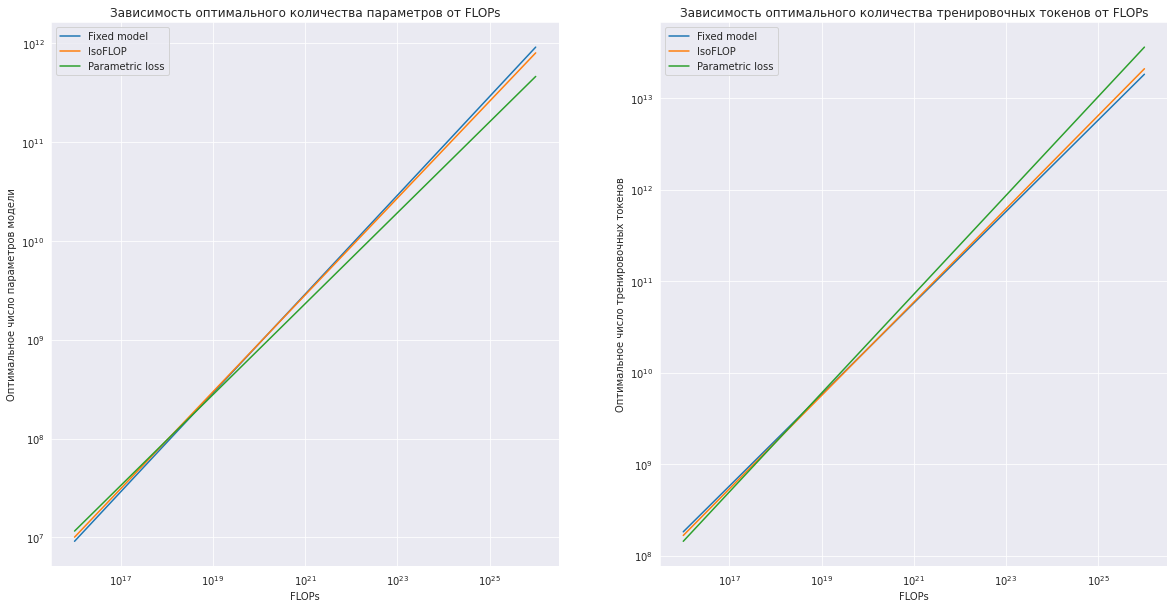

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (20, 10)

def draw_capacity_plots(capacity: np.ndarray) -> None:
    plt.subplot(1, 2, 1)
    plt.plot(capacity, fixed_model_N_opt(capacity), label="Fixed model")
    plt.plot(capacity, isoflop_N_opt(capacity), label="IsoFLOP")
    plt.plot(capacity, parametric_loss_N_opt(capacity), label="Parametric loss")
    plt.title("Зависимость оптимального количества параметров от FLOPs")
    plt.xlabel("FLOPs")
    plt.ylabel("Оптимальное число параметров модели")
    plt.semilogx()
    plt.semilogy()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(capacity, fixed_model_D_opt(capacity), label="Fixed model")
    plt.plot(capacity, isoflop_D_opt(capacity), label="IsoFLOP")
    plt.plot(capacity, parametric_loss_D_opt(capacity), label="Parametric loss")
    plt.title("Зависимость оптимального количества тренировочных токенов от FLOPs")
    plt.xlabel("FLOPs")
    plt.ylabel("Оптимальное число тренировочных токенов")
    plt.semilogx()
    plt.semilogy()
    plt.legend()

    plt.show()


draw_capacity_plots(np.logspace(16, 26))

In [3]:
!nvidia-smi

Mon Dec  5 15:18:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power

In [5]:
# GHz * cores * floating-point operations per clock cycle per core (FP32)
cpu_flops = 2.2 * 2 * 32 * 1e9
print(f"CPU FLOPs: {cpu_flops}")

# FLOPs per core (FP32) * CUDA cores
gpu_flops = 8.1e12 * 2560
print(f"GPU FLOPs: {gpu_flops}")

CPU FLOPs: 140800000000.0
GPU FLOPs: 2.0736e+16


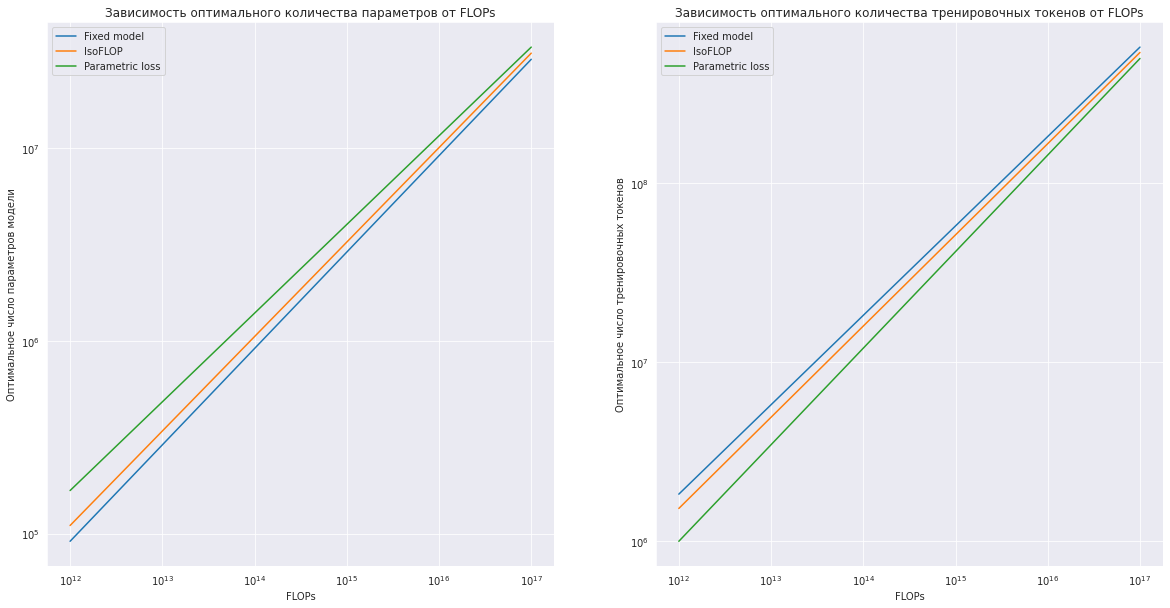

In [6]:
draw_capacity_plots(np.logspace(12, 17))

In [7]:
print(f"Optimal # of params for CPU: {round(fixed_model_N_opt(cpu_flops))}")
print(f"Optimal # of training tokens for CPU: {round(fixed_model_D_opt(cpu_flops))}")

Optimal # of params for CPU: 34254
Optimal # of training tokens for CPU: 685079


In [8]:
print(f"Optimal # of params for GPU: {round(fixed_model_N_opt(gpu_flops))}")
print(f"Optimal # of training tokens for GPU: {round(fixed_model_D_opt(gpu_flops))}")

Optimal # of params for GPU: 13145341
Optimal # of training tokens for GPU: 262906828


## Тренировка моделей с фиксированным размером выборки

In [9]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from transformers import BertForMaskedLM, BertConfig, BertTokenizerFast


def get_param_count(model: BertForMaskedLM) -> int:
    return sum(p.numel() for p in model.parameters())


tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [11]:
from datasets import load_dataset

xsum = load_dataset("xsum")
xsum

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [12]:
def encode(examples):
    return tokenizer(
        examples["document"],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )

xsum_train = xsum["train"].map(encode, batched=True, batch_size=10_000, remove_columns=["summary", "id"])
xsum_val = xsum["validation"].map(encode, batched=True, batch_size=10_000, remove_columns=["summary", "id"])
xsum_test = xsum["test"].map(encode, batched=True, batch_size=10_000, remove_columns=["summary", "id"])

  0%|          | 0/2 [00:00<?, ?ba/s]

In [13]:
len(xsum_train), len(xsum_val), len(xsum_test)

(204045, 11332, 11334)

In [14]:
from tqdm import trange

tokens = 0
for batch_start in trange(0, 60_000, 10_000):
    tokenized = tokenizer(
        xsum_train["document"][batch_start : batch_start + 10_000],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )["input_ids"]
    tokens += ((tokenized != tokenizer.bos_token_id) & (tokenized != tokenizer.sep_token_id) & (tokenized != tokenizer.pad_token_id)).sum()
    print(batch_start, tokens)

 17%|█▋        | 1/6 [00:19<01:35, 19.10s/it]

0 tensor(3545739)


 33%|███▎      | 2/6 [00:31<00:59, 14.91s/it]

10000 tensor(7096893)


 50%|█████     | 3/6 [00:42<00:40, 13.54s/it]

20000 tensor(10655196)


 67%|██████▋   | 4/6 [00:54<00:25, 12.73s/it]

30000 tensor(14172089)


 83%|████████▎ | 5/6 [01:06<00:12, 12.43s/it]

40000 tensor(17715097)


100%|██████████| 6/6 [01:19<00:00, 13.33s/it]

50000 tensor(21234365)


In [15]:
def opt_params_given_tokens(n_tokens: int) -> int:
    return fixed_model_N_opt((0.5477225575051662 * n_tokens) ** 2)

n_tokens = 21_234_365
print(f"Optimal # of params for GPU if the dataset has {n_tokens} tokens: {round(opt_params_given_tokens(n_tokens))}")

Optimal # of params for GPU if the dataset has 21234365 tokens: 1061718


In [16]:
models = [
    BertForMaskedLM(BertConfig(  # 4 219 322 params
        hidden_size=128,
        num_hidden_layers=2,
        num_attention_heads=16,
        intermediate_size=128
    )),
    BertForMaskedLM(BertConfig(  # 2 071 674 params
        hidden_size=64,
        num_hidden_layers=2,
        num_attention_heads=8,
        intermediate_size=64
    )),
    BertForMaskedLM(BertConfig(  # 1 037 786 params (closest to optimal)
        hidden_size=32,
        num_hidden_layers=2,
        num_attention_heads=4,
        intermediate_size=32
    )),
    BertForMaskedLM(BertConfig(  # 530 826 params
        hidden_size=16,
        num_hidden_layers=2,
        num_attention_heads=2,
        intermediate_size=16
    )),
    BertForMaskedLM(BertConfig(  # 279 842 params
        hidden_size=8,
        num_hidden_layers=2,
        num_attention_heads=1,
        intermediate_size=8
    ))
]

In [17]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from tqdm import tqdm

losses = []
for model in tqdm(models):
    print(f"Current model parameter count: {get_param_count(model)}")
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=str(get_param_count(model)),
            do_train=True,
            do_eval=True,
            evaluation_strategy="epoch",
            num_train_epochs=1.0,  # the authors trained their models for (at most) 1 epoch!
            report_to="none",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
        ),
        train_dataset=xsum_train.select(range(50_000)),
        eval_dataset=xsum_val,
        data_collator=DataCollatorForLanguageModeling(
            tokenizer=tokenizer,
        ),
        tokenizer=tokenizer,
    )
    trainer.train()
    losses.append(trainer.evaluate(xsum_test)['eval_loss'])

  0%|          | 0/5 [00:00<?, ?it/s]

Current model parameter count: 4219322


The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: document. If document are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 4219322
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text 

Epoch,Training Loss,Validation Loss
1,7.036700,7.030655


Saving model checkpoint to 4219322/checkpoint-500
Configuration saved in 4219322/checkpoint-500/config.json
Model weights saved in 4219322/checkpoint-500/pytorch_model.bin
tokenizer config file saved in 4219322/checkpoint-500/tokenizer_config.json
Special tokens file saved in 4219322/checkpoint-500/special_tokens_map.json
Saving model checkpoint to 4219322/checkpoint-1000
Configuration saved in 4219322/checkpoint-1000/config.json
Model weights saved in 4219322/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in 4219322/checkpoint-1000/tokenizer_config.json
Special tokens file saved in 4219322/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to 4219322/checkpoint-1500
Configuration saved in 4219322/checkpoint-1500/config.json
Model weights saved in 4219322/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in 4219322/checkpoint-1500/tokenizer_config.json
Special tokens file saved in 4219322/checkpoint-1500/special_tokens_map.json
Saving model check

 20%|██        | 1/5 [10:59<43:57, 659.38s/it]PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: document. If document are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 2071674


Current model parameter count: 2071674


Epoch,Training Loss,Validation Loss
1,7.133300,7.126016


Saving model checkpoint to 2071674/checkpoint-500
Configuration saved in 2071674/checkpoint-500/config.json
Model weights saved in 2071674/checkpoint-500/pytorch_model.bin
tokenizer config file saved in 2071674/checkpoint-500/tokenizer_config.json
Special tokens file saved in 2071674/checkpoint-500/special_tokens_map.json
Saving model checkpoint to 2071674/checkpoint-1000
Configuration saved in 2071674/checkpoint-1000/config.json
Model weights saved in 2071674/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in 2071674/checkpoint-1000/tokenizer_config.json
Special tokens file saved in 2071674/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to 2071674/checkpoint-1500
Configuration saved in 2071674/checkpoint-1500/config.json
Model weights saved in 2071674/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in 2071674/checkpoint-1500/tokenizer_config.json
Special tokens file saved in 2071674/checkpoint-1500/special_tokens_map.json
Saving model check

 40%|████      | 2/5 [19:10<28:01, 560.39s/it]PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: document. If document are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 1037786


Current model parameter count: 1037786


Epoch,Training Loss,Validation Loss
1,7.928400,7.898897


Saving model checkpoint to 1037786/checkpoint-500
Configuration saved in 1037786/checkpoint-500/config.json
Model weights saved in 1037786/checkpoint-500/pytorch_model.bin
tokenizer config file saved in 1037786/checkpoint-500/tokenizer_config.json
Special tokens file saved in 1037786/checkpoint-500/special_tokens_map.json
Saving model checkpoint to 1037786/checkpoint-1000
Configuration saved in 1037786/checkpoint-1000/config.json
Model weights saved in 1037786/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in 1037786/checkpoint-1000/tokenizer_config.json
Special tokens file saved in 1037786/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to 1037786/checkpoint-1500
Configuration saved in 1037786/checkpoint-1500/config.json
Model weights saved in 1037786/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in 1037786/checkpoint-1500/tokenizer_config.json
Special tokens file saved in 1037786/checkpoint-1500/special_tokens_map.json
Saving model check

 60%|██████    | 3/5 [26:57<17:15, 517.83s/it]PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: document. If document are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 530826


Current model parameter count: 530826


Epoch,Training Loss,Validation Loss
1,8.895400,8.872646


Saving model checkpoint to 530826/checkpoint-500
Configuration saved in 530826/checkpoint-500/config.json
Model weights saved in 530826/checkpoint-500/pytorch_model.bin
tokenizer config file saved in 530826/checkpoint-500/tokenizer_config.json
Special tokens file saved in 530826/checkpoint-500/special_tokens_map.json
Saving model checkpoint to 530826/checkpoint-1000
Configuration saved in 530826/checkpoint-1000/config.json
Model weights saved in 530826/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in 530826/checkpoint-1000/tokenizer_config.json
Special tokens file saved in 530826/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to 530826/checkpoint-1500
Configuration saved in 530826/checkpoint-1500/config.json
Model weights saved in 530826/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in 530826/checkpoint-1500/tokenizer_config.json
Special tokens file saved in 530826/checkpoint-1500/special_tokens_map.json
Saving model checkpoint to 530826

 80%|████████  | 4/5 [33:51<07:56, 476.67s/it]PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: document. If document are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 279842


Current model parameter count: 279842


Epoch,Training Loss,Validation Loss
1,9.526500,9.513021


Saving model checkpoint to 279842/checkpoint-500
Configuration saved in 279842/checkpoint-500/config.json
Model weights saved in 279842/checkpoint-500/pytorch_model.bin
tokenizer config file saved in 279842/checkpoint-500/tokenizer_config.json
Special tokens file saved in 279842/checkpoint-500/special_tokens_map.json
Saving model checkpoint to 279842/checkpoint-1000
Configuration saved in 279842/checkpoint-1000/config.json
Model weights saved in 279842/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in 279842/checkpoint-1000/tokenizer_config.json
Special tokens file saved in 279842/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to 279842/checkpoint-1500
Configuration saved in 279842/checkpoint-1500/config.json
Model weights saved in 279842/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in 279842/checkpoint-1500/tokenizer_config.json
Special tokens file saved in 279842/checkpoint-1500/special_tokens_map.json
Saving model checkpoint to 279842

100%|██████████| 5/5 [40:18<00:00, 483.74s/it]


In [18]:
for model, loss in zip(models, losses):
    print(f"Params: {get_param_count(model)}, test loss: {loss}")

Params: 4219322, test loss: 7.029702663421631
Params: 2071674, test loss: 7.124332904815674
Params: 1037786, test loss: 7.897958278656006
Params: 530826, test loss: 8.872184753417969
Params: 279842, test loss: 9.513030052185059


## Тренировка моделей с фиксированным количеством параметров и изменяющимся размером выборки

In [21]:
def opt_tokens_given_params(n_params: int) -> int:
    return 10.954451150103324 / 0.5477225575051662 * n_params

n_params = 1_037_786
print(f"Optimal # of tokens for GPU if the model has {n_params} params: {round(opt_tokens_given_params(n_params))}")

Optimal # of tokens for GPU if the model has 1037786 params: 20755720


In [23]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from tqdm import tqdm

trainer = Trainer(
    model=BertForMaskedLM(BertConfig(  # 1 037 786 params
        hidden_size=32,
        num_hidden_layers=2,
        num_attention_heads=4,
        intermediate_size=32
    )),
    args=TrainingArguments(
        output_dir="1037786_fixed",
        do_train=True,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=10000 / 16,  # to have a 10000 step in dataset size
        num_train_epochs=1.0,  # the authors trained their models for (at most) 1 epoch!
        report_to="none",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
    ),
    train_dataset=xsum_train.select(range(70_000)),
    eval_dataset=xsum_test,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
    ),
    tokenizer=tokenizer,
)
trainer.train()

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: document. If document are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 70000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4375
  Number of trainable parameters = 1037786


Step,Training Loss,Validation Loss
625,9.883700,9.287060
1250,9.125200,8.530053
1875,8.536800,7.994052
2500,7.778200,7.651535
3125,7.568000,7.457628
3750,7.448000,7.369921
4375,7.372600,7.343834


Saving model checkpoint to 1037786_fixed/checkpoint-500
Configuration saved in 1037786_fixed/checkpoint-500/config.json
Model weights saved in 1037786_fixed/checkpoint-500/pytorch_model.bin
tokenizer config file saved in 1037786_fixed/checkpoint-500/tokenizer_config.json
Special tokens file saved in 1037786_fixed/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: document. If document are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 11334
  Batch size = 16
Saving model checkpoint to 1037786_fixed/checkpoint-1000
Configuration saved in 1037786_fixed/checkpoint-1000/config.json
Model weights saved in 1037786_fixed/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in 1037786_fixed/checkpoint-1000/tokenizer_config.json
Special tokens file saved in 1037786_fixed/checkpoint-1000/s

TrainOutput(global_step=4375, training_loss=8.1493859375, metrics={'train_runtime': 693.3853, 'train_samples_per_second': 100.954, 'train_steps_per_second': 6.31, 'total_flos': 9598095360000.0, 'train_loss': 8.1493859375, 'epoch': 1.0})